# **Colabユーザーへの注意**

# **このファイルに直接書き込まないでください—作業が消えることがあります！**

# **必ず作業前にコピーを作成してください。**

コピーの作り方

1. 左上の「File」をクリック  
> *「File」や「Runtime」などのメニューが見えないときは、右上の“v”マークを押して表示してください。*

2. 「Save a copy in Drive」を選ぶ  

3. コピーしたファイル名を「YOURNAMEs_FileName.ipynb」に変更する  
> 例：名前がOliviaなら → Olivias_FileName.ipynb  


---

* チェックマーク（✅）は保存されません。Chromeのリロードボタンでページを更新すると消えます。<br>  
途中で止めるときは、テキストセルを追加して「SO FAR DONE」など書いておいてください。

---

* Colabでは**30分〜90分ごとに以前の出力結果がリセットされます**。<br>  
そのため、`~~ is not defined`のようなエラーが**すごくよく起こります**。

🔁 `~~ is not defined`エラーが出たらどうする？

1. まず変数名のスペルを確認してください。<br>  
2. スペルが正しいのにまだエラーが出るなら、**そのセルをクリックして選択**してください。<br>  
3. 左上の「Runtime」→「Run before」をクリック。<br>  
→ これで**それまでのすべてのセルが再実行されます**。  
4. 再度、そのセルを実行してください。

もしこれでもエラーが直らなければ、<br>  
前のセルのTODOの答えに基本的なミスがあるかもしれません。<br>  
正しいかどうか確認してください。<br>  
またはChatGPTや他のコーディングアシスタントに助けを求めましょう。

# **Preparation**

このセクションでは前のChapterの内容を読み込むだけです。<br>
コードを実行するだけでOK。読まなくても大丈夫です。<br>
気軽に先へ進んでください。<br>

In [ ]:
# ファイルをダウンロードしてください
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# utf-8でダウンロードしたinput.textファイルを読み込む。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# テンソルを見やすく表示する関数（任意）
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
        A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("名前", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """
    
    # 引数からテンソルと名前を判定する
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Tensorをリストに変換する
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """再帰的ネストリストの整形と文字列返却"""
        # 内容がリストなら再度返す
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # 番号付きリスト用
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # フォーマット済み文字列（最外枠の中括弧は除く）
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # 結果出力
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("テンソル([")
    print("" * 9 + inner_formatted)
    print("" * 7 + "])")

--2025-07-08 11:25:56--  https://raw.githubusercontent.com/HayatoHongo/nanoGPT_todo/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-07-08 11:25:56 (31.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



# **Chapter 12 Trainer クラス**

### **Section 1: クラス定義**

🔘 **Options**: 不要な追加オプションがあるかもしれません。

`self.model`　`self.optimizer`　`self.data_loader`　`self.config`　`split_data`　`get_batch`　`'train'`, `'val'`　`input_batch`　`target_batch`　`logits`　`self.config.total_training_steps`　`self.config.evaluation_loops`  
`loss`　`backward()`　`self.train_step()`　`self.evaluate()`

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # 訓練用バッチを取得する。
        input_batch, target_batch = self.data_loader.get_batch('train')
        self.optimizer.zero_grad()

        # モデルの順伝播と損失計算
        logits, loss = self.model(input_batch, target_batch)
        loss.backward()  # 誤差逆伝播法
        self.optimizer.step()  # パラメータを更新する

        return loss.item() # 損失の値を返す

    def evaluate(self):
        self.model.eval()  # 評価モードに設定する
        losses = {"train": [], "val": []} # 訓練と検証の損失を計算する
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # トレーニングモードに戻る

        # 各分割（train, val）の平均損失を計算する
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # configで指定された回数だけtrain_stepを実行する。
        for step in range(self.config.total_training_steps):

            # 100回ごと、または最終ステップのみ評価する。
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # 1回の学習ステップ（毎回行う主な処理）
            train_loss = self.train_step()

In [ ]:
"""
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # 訓練用のバッチを取得する。
        input_batch, target_batch = ___________._______(_____)
        self.optimizer.zero_grad()

        # モデルの順伝播と損失計算
        logits, loss = _______(_________, __________)
        _____.__________  # 逆伝播（誤差逆伝播）
        self.optimizer.step()  # パラメータを更新する

        return loss.item() # 損失の値を返す

    def evaluate(self):
        self.model.eval()  # 評価モードに設定する
        losses = {"train": [], "val": []} # 学習・検証データの損失を計算する
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # 学習モードに戻る

        # 各分割(train, val)の平均損失を計算する
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # configで指定された回数だけtrain_stepを実行する。
        for step in range(_________________________):

            # 100回ごとまたは最終ステップで評価する。
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # 1ステップの学習（毎回行う主要処理）
            train_loss = _____________
"""


'\nclass Trainer:\n    def __init__(self, model, optimizer, data_loader, config):\n        self.model = model\n        self.optimizer = optimizer\n        self.data_loader = data_loader\n        self.config = config\n\n    def train_step(self):\n        # Get a batch for training.\n        input_batch, target_batch = ___________._______(_____)\n        self.optimizer.zero_grad()\n\n        # Model forward pass and loss calculation\n        logits, loss = _______(_________, __________)\n        _____.__________  # Backpropagation (Error backpropagation)\n        self.optimizer.step()  # Update parameters\n\n        return loss.item() # Returns the value of the loss\n\n    def evaluate(self):\n        self.model.eval()  # Set to evaluation mode\n        losses = {"train": [], "val": []} # Calculate losses on both training and validation data\n        with torch.no_grad():\n            for split in [\'train\', \'val\']:\n                for _ in range(self.config.evaluation_loops):\n     

<details>
<summary>クリックして答えを表示/非表示</summary>

```python
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # トレーニング用バッチを取得。
        input_batch, target_batch = self.data_loader.get_batch('train')
        self.optimizer.zero_grad()

        # モデルの順伝播と損失計算
        logits, loss = self.model(input_batch, target_batch)
        loss.backward()  # 誤差逆伝播
        self.optimizer.step()  # パラメータ更新

        return loss.item() # 損失の値を返す

    def evaluate(self):
        self.model.eval()  # 評価モードに切り替え
        losses = {"train": [], "val": []} # 学習・検証データ両方の損失を計算
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # 再び学習モードへ戻す

        # 各データセット（train, val）での損失の平均を計算して返す
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # configで指定された回数だけtrain_stepを実行。
        for step in range(self.config.total_training_steps):

            # 100ステップごと、または最終ステップのみ評価を行う。
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # トレーニングの1ステップ（毎回行うメイン処理）
            train_loss = self.train_step()
```

**Chapter 11: Trainer Class: Section 1: クラス定義** <label><input type="checkbox"> Mark as Done</label>

### **Section 2: クラス概要**

Chapter 1からChapter 11までのすべてのクラスを貼り付けてください。<br>
**DeterministicDropoutはnn.Dropoutに置き換えてください。**

[Watch the video!](https://youtu.be/j2ErzvlslKA)
- 音声なし
- 4分

動画内のファイル名はanswer_colabですが、気にしないでください。

```python
AttentionHead: dropout = nn.Dropout(config.dropout_rate)
MultiHeadAttention: dropout = nn.Dropout(config.dropout_rate)
FeedForward:  nn.Dropout(config.dropout_rate)
```

In [ ]:
class DataLoader:
    def __init__(self, text, config):
        self.config = config  # 設定オブジェクト
        chars = sorted(list(set(text)))  # ユニークな文字をソートする
        self.ctoi = {char: index for index, char in enumerate(chars)}
        self.itoc = {index: char for index, char in enumerate(chars)}
        self.vocab_size = len(chars)

        # エンコードしてテンソルに変換する。
        # `__init__`外のメソッドや引数を呼ぶには`self.`が必要です。
        self.data = torch.tensor(self.encode(text), dtype=torch.long)

        # 訓練用と検証用に分割する。
        # 引数が指定されなくてもself.dataが使われます。
        self.train_data, self.val_data = self.split_data()

    def encode(self, text):
        # 文字列をインデックス列に変換します。self.で他のメソッドや引数を呼び出します。
        return [self.ctoi[c] for c in text]

    def decode(self, indices):
        return ''.join([self.itoc[i] for i in indices])

    def split_data(self):
        split_index = int(0.9 * len(self.data))  # データの90%を訓練用に分割するポイント。
        return self.data[:split_index], self.data[split_index:]

    def get_batch(self, split):
        data = self.train_data if split == 'train' else self.val_data
        start_indices = torch.randint(len(data) - self.config.input_sequence_length, (self.config.batch_size,)) # 抽出開始インデックスを生成する

        input_sequences = torch.stack([
            data[start_index:start_index + self.config.input_sequence_length]
            for start_index in start_indices
        ])
        target_sequences = torch.stack([
            data[start_index + 1:start_index + self.config.input_sequence_length + 1]
            for start_index in start_indices
        ])
        return input_sequences.to(self.config.device_type), target_sequences.to(self.config.device_type)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 語彙数x埋め込み次元の埋め込みテーブルを定義する
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 入力インデックスに対応する埋め込みベクトルを取得する
        return self.token_embedding_table.forward(input_indices)

class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置埋め込み層
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 入力テンソル input_indices の形状：[バッチサイズ、シーケンス長]。
        sequence_length = input_indices.shape[1]

        # シーケンス長に応じた位置インデックスを作成する（例：[0, 1, 2, ..., sequence_length-1]）
        position_indices = torch.arange(sequence_length, device=input_indices.device)

        # 位置インデックスの埋め込みベクトルを取得する
        position_embeddings = self.position_embedding_layer.forward(position_indices)

        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 各トークンの埋め込み層
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)  # 単語埋め込み層
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)  # 位置情報を埋め込む

    def forward(self, input_indices):
        # トークン埋め込みを取得
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # 位置埋め込みを取得する
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # トークン埋め込みと位置埋め込みを追加する
        embeddings = position_embeddings + token_embeddings
        return embeddings

class LayerNorm(nn.Module):  # ここでnn.Moduleを継承する
    def __init__(self, token_length, eps=1e-5, norm_dim=-1):
        super().__init__()
        self.eps = eps
        self.norm_dim = norm_dim

        # gamma と beta を nn.Parameter として登録し、CPU と CUDA の両方で使用できるようにする
        self.gamma = nn.Parameter(torch.ones(token_length))
        self.beta = nn.Parameter(torch.zeros(token_length))

    def forward(self, x):
        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)
        var = torch.var(x, dim=self.norm_dim, keepdim=True, unbiased=False)
        hat = (x - mean) / torch.sqrt(var + self.eps)
        output =  self.gamma * hat + self.beta
        return output


class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # マスクは下三角行列で作成されます（自己注意の因果性を保持）
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # ドロップアウト（決定版は別定義）
        self.dropout = nn.Dropout(config.dropout_rate)

        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # バッチ、トークン長、埋め込みチャネル

        Key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        Query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        Value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # Attentionスコアを計算中 (QK^T) / sqrt(embedding_dim)
        attention_weights_before_mask = Query @ Key.transpose(-2, -1) * self.head_size**(-0.5)

        # マスク適用済み
        mask = torch.triu(torch.ones(T, T), diagonal=1).to(input_tensor.device)
        masked_attention_weights = attention_weights_before_mask.masked_fill(mask == 1, float('-inf'))

        # ソフトマックス → ドロップアウト → 重み付き和
        attention_weights = F.softmax(masked_attention_weights, dim=-1)
        attention_weights = self.dropout(attention_weights)

        out = attention_weights @ Value  # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # ModuleListで複数のヘッドを管理する
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # 各ヘッドの出力を混合する線形層
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # 出力のドロップアウト
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, input_tensor):
        # 各ヘッドの出力を取得する
        # (B, T, head_size)のリスト
        head_outputs_list = [head.forward(input_tensor) for head in self.attention_heads]

        # 全てのヘッドの出力を連結 → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # 線形変換での出力混合
        projected = self.output_projection.forward(concatenated)

        # 最終出力にドロップアウトを適用する
        output = self.dropout.forward(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.embedding_dim),
            nn.Dropout(config.dropout_rate),
        )

    def forward(self, input_tensor):
        return self.net(input_tensor)

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # 各LayerNormは独自のbetaとgammaを保持します。
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        # forwardメソッドは省略されています。
        normed_input = self.layer_norm1(input_tensor) # 入力にレイヤーノルムを適用する
        attention_output = self.multihead_attention(normed_input) # マルチヘッドアテンションを適用する
        residual_attention = attention_output + input_tensor # "before! layernorm1"を追加
        normed_attention = self.layer_norm2(residual_attention) # 残差出力に再度LayerNormを適用する
        feedforward_output = self.feed_forward(normed_attention) # フィードフォワードネットワークを適用する
        final_output = feedforward_output + residual_attention # "before" layernorm2 を追加する！

        return final_output

class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # レイヤー正規化
        self.output_norm = nn.LayerNorm(config.embedding_dim)
        # 語彙数の射影
        self.vocab_projection = nn.Linear(config.embedding_dim, vocab_size)

    def forward(self, transformer_block_output):
        # Transformerブロックの出力にLayer normalizationを適用する。
        normalized_output = self.output_norm.forward(transformer_block_output)  # (B, T, C)

        # 線形層でスコアを語彙数次元に変換する。
        vocab_logits = self.vocab_projection.forward(normalized_output)  # (B, T, V)

        return vocab_logits

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # 生成時にも使うので保持してください。
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()

    # テキストを生成する
    def generate(self, input_indices, max_new_tokens):
        # 指定したトークン数max_new_tokensのみ生成する
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, -self.config.input_sequence_length:] # 入力を切り取る

            # 順伝播は `(likelihood, loss)` を返す—`likelihood` のみを `logits` として保持する。
            logits, _ = self.forward(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # 最後のトークンのロジットを抽出する
            probs = F.softmax(last_logits, dim=-1) # Softmaxで尤度を確率に変換する

            # 次のトークンをサンプリングする
            next_token = torch.multinomial(probs, num_samples=1)

            # 新しいトークンを統合し、input_indicesを更新する。
            input_indices = torch.cat((input_indices, next_token), dim=1)

        # 最終的な`input_indices`を返す。長さは元の`input_indices`＋`max_new_tokens`
        return input_indices

    # 尤度と損失を計算する
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # 推論時はターゲットがないため、lossはNoneです
        # —確率（ロジット）のみ返されます。
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)
        loss = self.criterion(logits, targets)

        return logits, loss

**DeterministicDropoutをnn.Dropoutに置き換える**
```python
AttentionHead: dropout = nn.Dropout(config.dropout_rate)
MultiHeadAttention: dropout = nn.Dropout(config.dropout_rate)
FeedForward:  nn.Dropout(config.dropout_rate)
```
<label><input type="checkbox"> Done</label>

**`Chapter 12: Trainer Class: Section 2: クラス概要`** <label><input type="checkbox"> Mark as Done</label>

### **Section 3: トレーニングと推論**

これまでは埋め込み次元が8、アテンションヘッドが2つ、FeedForwardネットワークの隠れ層が16次元でした。<br>
これは表現力としてはあまりに限られています。<br>
今度は埋め込み次元を64、アテンションヘッドを4つ、FeedForwardネットワークの隠れ層を256次元に設定します。

In [ ]:
# モデル設定を保存する設定クラス
class ModelConfig:
    batch_size = 16  # 一度に処理するデータ数（バッチサイズ）
    input_sequence_length = 32  # 入力データの長さ（系列長）
    total_training_steps = 5000  # 最大トレーニング回数（ステップ数）
    evaluation_frequency = 100  # モデル性能評価の頻度
    learning_rate = 0.001  # 学習率
    device_type = 'cuda' if torch.cuda.is_available() else 'cpu'  # 使用デバイス（GPUまたはCPU）
    evaluation_loops = 10  # 評価中の繰り返し回数
    embedding_dim = 64  # 埋め込み層サイズ（特徴ベクトルの次元数）
    hidden_dim = 256
    num_attention_heads = 4  # ノート機構ヘッド番号
    layer_count = 4  # モデルの層数
    dropout_rate = 0.1  # ドロップアウト確率
    random_seed_value = 1337  # 再現性のための乱数シード

# 設定を確認してください
config = ModelConfig()

print("ModelConfigクラスの各設定:")
print(f"Batch size: {config.batch_size}")
print(f"Input sequence length: {config.input_sequence_length}")
print(f"Total training steps: {config.total_training_steps}")
print(f"Evaluation frequency (in steps): {config.evaluation_frequency}")
print(f"Learning rate: {config.learning_rate}")
print(f"Device in use: {config.device_type}")
print(f"Number of evaluation loops: {config.evaluation_loops}")
print(f"Embedding vector dimension: {config.embedding_dim}")
print(f"Hidden layer dimension of the feedforward network: {config.hidden_dim}")
print(f"Number of attention heads: {config.num_attention_heads}")
print(f"Number of model layers: {config.layer_count}")
print(f"Dropout rate: {config.dropout_rate}")
print(f"Random seed value: {config.random_seed_value}")

Each setting for the ModelConfig class:
Batch size: 16
Input sequence length: 32
Total training steps: 5000
Evaluation frequency (in steps): 100
Learning rate: 0.001
Device in use: cuda
Number of evaluation loops: 10
Embedding vector dimension: 64
Hidden layer dimension of the feedforward network: 256
Number of attention heads: 4
Number of model layers: 4
Dropout rate: 0.1
Random seed value: 1337


**`Check Point`**  
<label><input type="checkbox"> Configクラスの設定が正しく表示されているか確認しよう<br></label>  
- バッチサイズ: 16<br>  
- ブロックサイズ: 32<br>  
- 最大繰り返し回数: 5000<br>  
- 評価間隔: 100<br>  
- 学習率: 0.001<br>  
- 使用デバイス: cuda または cpu<br>  
- 評価時の繰り返し回数: 10<br>  
- 埋め込み層の次元数: 64<br>  
- フィードフォワード層の隠れ次元数: 256<br>  
- アテンションヘッド数: 4<br>  
- モデルの層数: 4<br>  
- ドロップアウト率: 0.1<br>  
- シード値: 1337<br>

In [ ]:
# 設定を読み込みシードを設定する
config = ModelConfig()
torch.manual_seed(config.random_seed_value)  # 再現性確保のため乱数シードを設定

In [ ]:
# データを読み込む
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text_data = f.read()
data_loader = DataLoader(text_data, config)

In [ ]:
# モデルとオプティマイザを初期化する
model = BigramLanguageModel(vocab_size = data_loader.vocab_size, config = config).to(config.device_type)  # 使用するデバイスを指定してください
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# モデルのパラメータ数を表示する
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.209729 M parameters


比較すると、GPT2-Smallモデルは1億1700万（または1億2400万）パラメータを持っています。

テストとして、事前学習の段階で生成を試してみてください。

In [ ]:
text = "Let's he"  # プロンプト
initial_context = torch.tensor(data_loader.encode(text), dtype=torch.long)
# unsqueeze(0)でバッチ次元を追加（バッチサイズ1）
initial_context_unsqueeze = initial_context.unsqueeze(0)
# ↓ ポイントは使用中のデバイスに移すこと（CPUかGPU）！
initial_context_unsqueeze = initial_context_unsqueeze.to(config.device_type)

# 生成を開始する
generated_sequence_initial = model.generate(initial_context_unsqueeze, max_new_tokens=500)
print(data_loader.decode(generated_sequence_initial[0].tolist()))

Let's henvIeuW;JcijkeLWfUaUJW;VcE!Pf;ocFF&oNhq$eQLJOOEFWXgjNhhqv;Es
iowD&ZqK&CgwN'Pq$mFHGjX.esumfonqUzgrN?pNVvN!Iebiqfs!EuOt3Zw?Bjx$oYk-wXmvevRibdVde!eJgRLKasNnge?DEYpK! 'scfoOl!Ebe$iol$-UpfXGKtewgLMsO!?fX?&D?;-$zBR.SudGdOo.&co
zvzNqQriRR'QbHbs'QqXghiHWJwLUEZE&pNz
T'Rk!ZgbN?tmE.uJaekBK?Oh&n&Um,LDqc'omcC&Z;xpZGipgRQeN$y?VDbOvsN,$IcNhepTHJeWkzKdrf?roHm?dfwFUpwMVg;ei&$RCXTyowaFZhjVBm$3g33cAuh,K?UlAGcX;p!JUlNvvbIHG.3inUc.HjMCsyhnpwAKylbSHT'pXh3UNfO:mreo'VrL'cpe-NC,ntZAziOpKcpTOE.hs:Ck&z'LGJgyb3?p!3fI,OjzFHE


うーん、これはコンピュータ💻だね？

それなら、さあ訓練して赤ちゃん👶に育てよう！

**ついに最後のパートにたどり着きました。[感動のBGM¹](https://youtu.be/GqmAe0QfkjU?feature=shared)スタート！<br>トレーニングはだいたい2〜4分かかります。今この瞬間をじっくり味わいましょう。**

---

参考コンテンツ:  
¹ **DooPiano**, 「BTS (방탄소년단) – 봄날 (Spring Day) ピアノ＆ストリングオーケストラバージョン」、YouTube、3:41、約8.2年前公開（2017年頃）。2025年7月8日アクセス。

---

**ぜひBGMを聴いてください！心が動くこと間違いなし！さあ、下のセルを実行してトレーニングを始めましょう！**

In [ ]:
print("===トレーニングが正常に開始されました===")

# モデルを学習する
trainer = Trainer(model, optimizer, data_loader, config)
trainer.train()

# モデルを保存中
save_path = "bigram_language_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, save_path)

print("学習完了")
print(f"Model and optimizer state saved to {save_path}")

===TRAINING STARTED SUCCESSFULLY===
Step 0: Train Loss 2.3080, Validation Loss 2.3095
Step 100: Train Loss 2.2592, Validation Loss 2.2887
Step 200: Train Loss 2.2122, Validation Loss 2.2228
Step 300: Train Loss 2.1850, Validation Loss 2.1929
Step 400: Train Loss 2.1433, Validation Loss 2.1610
Step 500: Train Loss 2.0731, Validation Loss 2.1434
Step 600: Train Loss 2.0713, Validation Loss 2.1265
Step 700: Train Loss 2.0781, Validation Loss 2.0784
Step 800: Train Loss 2.0399, Validation Loss 2.1171
Step 900: Train Loss 1.9939, Validation Loss 2.0921
Step 1000: Train Loss 2.0463, Validation Loss 2.0800
Step 1100: Train Loss 2.0031, Validation Loss 2.0437
Step 1200: Train Loss 1.9710, Validation Loss 2.0322
Step 1300: Train Loss 1.8837, Validation Loss 2.0148
Step 1400: Train Loss 1.9525, Validation Loss 2.0299
Step 1500: Train Loss 1.9432, Validation Loss 2.0055
Step 1600: Train Loss 1.9284, Validation Loss 1.9633
Step 1700: Train Loss 1.9180, Validation Loss 1.9909
Step 1800: Train Loss 

In [ ]:
# ---- 保存済みモデルの読み込みとテキスト生成 -----
# 新しいモデルとオプティマイザを初期化（同じ設定とクラス定義が必要）
loaded_model = BigramLanguageModel(vocab_size = data_loader.vocab_size, config = config).to(config.device_type)  # 使用するデバイスを指定してください
loaded_optimizer = torch.optim.AdamW(loaded_model.parameters(), lr=config.learning_rate)

save_path = "bigram_language_model.pth"
checkpoint = torch.load(save_path, map_location=config.device_type)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("=====モデルの読み込みに成功しました！=====")

===== Model Loaded Successfully!=====


モデルを評価モードに設定します。生成前にDropoutを無効にしてください。

忘れるとDropoutがオンになり、出力がひどくなるので注意しましょう。

In [ ]:
loaded_model.eval()
print("===== 評価モードに設定、Dropout無効。 =====")

===== Set to Evaluation mode, disabled Dropout. =====


In [ ]:
prompt = "Let's he"  # プロンプト
encoded_prompt = torch.tensor(data_loader.encode(prompt), dtype=torch.long)
print_formatted_tensor("エンコード済みプロンプト", encoded_prompt)

encoded_prompt
Tensor Size: [8]
tensor([
         24.00,  43.00,  58.00,   5.00,  57.00,   1.00,  46.00,  43.00
       ])


In [ ]:
# unsqueeze(0)でバッチ次元を追加（バッチサイズ1）
encoded_prompt_unsqueeze = encoded_prompt.unsqueeze(0)
print_formatted_tensor("エンコード済みプロンプトの次元追加", encoded_prompt_unsqueeze)

encoded_prompt_unsqueeze
Tensor Size: [1, 8]
tensor([
         [ 24.00,  43.00,  58.00,   5.00,  57.00,   1.00,  46.00,  43.00]
       ])


In [ ]:
# ↓ ここで重要なのは、プロンプトテンソルを使用中のデバイス（CPUまたはGPU）に移動することです！
encoded_prompt_unsqueeze = encoded_prompt_unsqueeze.to(config.device_type)

```python
インスタンス: loaded_model
メソッド: generate
引数: encoded_prompt_unsqueeze, max_new_tokens=1000
```

In [ ]:
# 生成を開始
generated_sequence = loaded_model.generate(encoded_prompt_unsqueeze, max_new_tokens=1000) # TODO: インスタンス、
print(data_loader.decode(generated_sequence[0].tolist()))

Let's he weath to begiver thing thou are perpisency the gertater sing
To With beenes; no from to the chaul!

JUTIO:
Were this not the carence your in singrard hath lond
Capus leet.

BRUTUS:
Thee bust to me to speaks or his it,

Deseetock untertay laid I wand for shing
that ittience, God nig for the from do it it.

Pervore, I sethall thou breather,
By tyre agent man some thou my servery plaid be the spoble.

GLOUCESTER:
Shallo, Say fauls I weick.

DUCESTER MARGAREY:
My noble thear, an, and at to he's guend
For me full I say's be swould Gentleat haph till
Nor And being years their rlancues
The Last burssened to her be gry our sto stoot
Ands that nurse steep
Of aund will of her age man, tiSingment your boy's rings:
Your my and again and well I would theur ady
A samernon to do time'n sail thou lack your juty,
No? I coundertife thou have thee other awarthrough a dne'd I preaty
Waveichard him time if our good bowers highne:
Thears.

Thidds; and I' weal theseity. Bollow Richions:
As City you?

赤ちゃん👶レベルまで進んだ？

今回はnanoGPTで、コンピュータ💻から赤ちゃん👶へステップアップ。

次はGPT2が赤ちゃん👶から中学生🧑へ成長するぞ！

**Chapter 12: Trainer Class: Section 3: トレーニングと推論** <label><input type="checkbox"> Mark as Done</label>

**`Chapter 12: The Trainer Class`** <label><input type="checkbox"> Mark as Done</label>

**`nanoGPT`** <label><input type="checkbox"> Done</label>

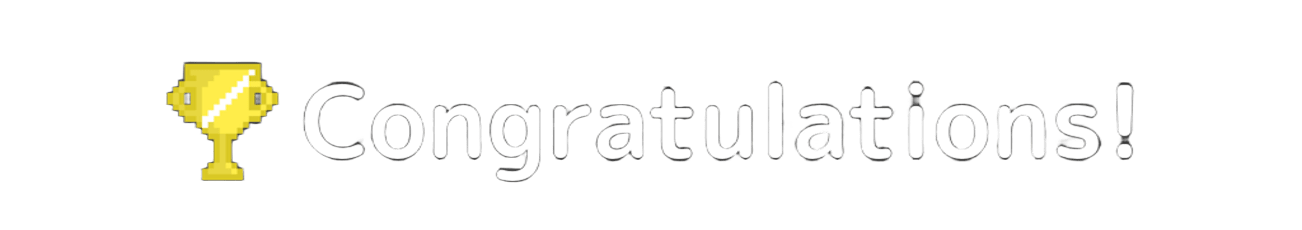